In [72]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'white', context = 'notebook', palette = 'deep')

from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [35]:
df = pd.read_csv("train.csv")

In [36]:
len(set(df.SibSp))

7

In [37]:
df_na = (df.isnull().sum()/len(df)) * 100
df_na = df_na.drop(df_na[df_na==0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({'Missing Ratio' : df_na})
missing_data.head(3)

,Missing Ratio
Cabin,77.104377
Age,19.865320
Embarked,0.224467


In [38]:
df.drop(df_na[df_na>20].index, axis = 1, inplace = True)

In [39]:
## drop those rows which contains missing values
df.dropna(how='any', inplace = True)

In [40]:
df = pd.concat([pd.get_dummies(df[['Pclass', 'Sex','SibSp','Embarked']]), df[['Age', 'Fare','Survived']]], axis=1)

In [41]:
df.shape

(712, 10)

In [43]:
X = df.drop(['Survived'], axis = 1)
y = df['Survived']
## split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## cross validate model with k-fold
kfold = StratifiedKFold(n_splits = 5)

In [44]:
## random forest
RF = RandomForestClassifier(random_state=7, n_jobs=-1)

## search grid for optimal parameters
rf_param_grid = {'n_estimators':[120]}

gsRF_replied = GridSearchCV(RF, param_grid = rf_param_grid, cv = kfold,
                            n_jobs = -1, verbose = 5, scoring='roc_auc')
## Fit
gsRF_replied.fit(X_train, y_train)

RF_replied_best = gsRF_replied.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


In [47]:
gsRF_replied.cv_results_ ## looks like overfitting issue

{'mean_fit_time': array([ 0.17789655]),
 'mean_score_time': array([ 0.10529895]),
 'mean_test_score': array([ 0.83925576]),
 'mean_train_score': array([ 0.99966699]),
 'param_n_estimators': masked_array(data = [120],
              mask = [False],
        fill_value = ?),
 'params': [{'n_estimators': 120}],
 'rank_test_score': array([1]),
 'split0_test_score': array([ 0.80869565]),
 'split0_train_score': array([ 0.99988889]),
 'split1_test_score': array([ 0.80096618]),
 'split1_train_score': array([ 0.99986869]),
 'split2_test_score': array([ 0.85990338]),
 'split2_train_score': array([ 0.99954545]),
 'split3_test_score': array([ 0.87745572]),
 'split3_train_score': array([ 0.99947475]),
 'split4_test_score': array([ 0.84934641]),
 'split4_train_score': array([ 0.99955717]),
 'std_fit_time': array([ 0.00470099]),
 'std_score_time': array([ 0.00045318]),
 'std_test_score': array([ 0.02964527]),
 'std_train_score': array([ 0.00017533])}

In [45]:
confusion_matrix(y_train, RF_replied_best.predict(X_train))

array([[341,   3],
       [  5, 220]], dtype=int64)

In [46]:
confusion_matrix(y_test, RF_replied_best.predict(X_test))

array([[67, 13],
       [18, 45]], dtype=int64)

In [50]:
pred_prob_rf = RF_replied_best.predict_proba(X_test)[:,1]

In [51]:
roc_auc_score(y_test, pred_prob_rf)

0.84682539682539681

In [52]:
# get roc curve
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob_rf)
roc_auc = metrics.auc(fpr,tpr)

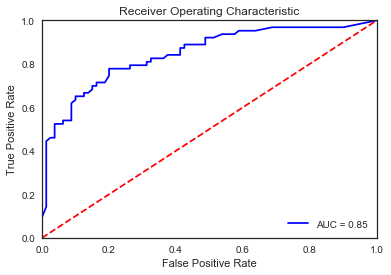

In [53]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [55]:
RF = RandomForestClassifier(n_jobs = -1, n_estimators = 120)
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

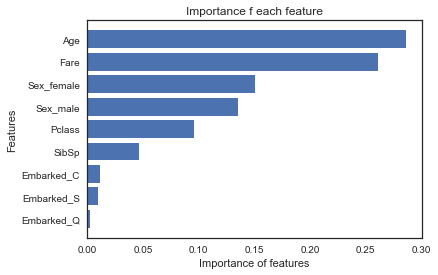

In [60]:
feature_importance = pd.DataFrame({'Importance':RF.feature_importances_}, 
                                  index=X_train.columns).sort_values(by=['Importance'],ascending=False).head(10).sort_values(by=['Importance'],ascending=True)

plt.barh(range(len(feature_importance)), feature_importance.Importance, align = 'center')
plt.yticks(range(len(feature_importance)), feature_importance.index)

plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Importance f each feature')
plt.show()

In [64]:
## select number of features
consecutive_list = []
calc = 4

while int(calc) < 10:
    consecutive_list.append(calc)
    calc = int(calc) + 1
    
for i in consecutive_list:
    X_train_loop = X_train[feature_importance.iloc[np.arange(i)].index]
    X_test_loop = X_test[feature_importance.iloc[np.arange(i)].index]
    RF_loop = RandomForestClassifier(n_jobs = -1, random_state=24, n_estimators=120)
    RF_loop.fit(X_train_loop, y_train)
    print("with {} features, the roc score is {}.".format(i,roc_auc_score(y_test, RF_loop.predict_proba(X_test_loop)[:,1])))

with 4 features, the roc score is 0.6055555555555555.
with 5 features, the roc score is 0.6717261904761904.
with 6 features, the roc score is 0.7785714285714287.
with 7 features, the roc score is 0.7831349206349206.
with 8 features, the roc score is 0.7952380952380953.
with 9 features, the roc score is 0.8450396825396825.


### check number of parameters and cut-off point based on F1 score

In [66]:
scores = []

select_n_estimators = np.arange(10,51,10).astype('int')

for val in select_n_estimators:
    clf = RandomForestClassifier(n_estimators=val, n_jobs = -1, verbose = 1)
    validated = cross_val_score(clf, X_train, y_train, cv = 3, scoring='f1')
    scores.append(validated)

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: D

In [67]:
scores_table = pd.DataFrame(np.transpose(scores),
                            columns = select_n_estimators.astype('str'))

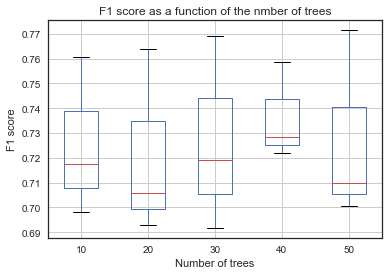

In [68]:
scores_table.boxplot()
plt.xlabel('Number of trees')
plt.ylabel('F1 score')
plt.title('F1 score as a function of the nmber of trees')
plt.show()

In [114]:
## find cutoff point that best for f1 score
def cutoff_predict(clf, X_train, cutoff):
    return(clf.predict_proba(X_train)[:,1] > cutoff).astype(int)

scores = []

def custom_f1(cutoff):
    def f1_cutoff(clf,X_train,y_train):
        ypred = cutoff_predict(clf, X_train, cutoff)
        return f1_score(y_train, ypred)
    return f1_cutoff

selected_f1_scores = 0.1 * np.round(np.arange(1,10,1),1)

for cutoff in selected_f1_scores:
    clf = RandomForestClassifier(n_estimators = 40, n_jobs = -1, verbose = 1)
    validated = cross_val_score(clf, X_train, y_train, cv = 5, scoring = custom_f1(cutoff))
    scores.append(validated)

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_j

In [115]:
scores_cutoff = pd.DataFrame(np.transpose(scores),
                             columns = np.round(selected_f1_scores,2).astype('str')) # round up error with np.arange

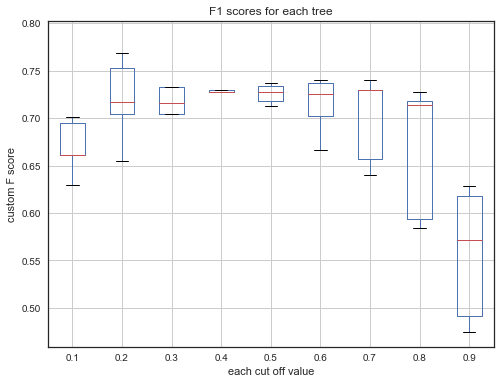

In [117]:
plt.figure(figsize=(8,6))
scores_cutoff.boxplot()
plt.title('F1 scores for each tree')
plt.xlabel('each cut off value')
plt.ylabel('custom F score')
plt.show()

In [120]:
for i in np.arange(0.4,0.5,0.01):
    print("the f1 score is {:0.4f} with cutoff point at {:0.2f}".format(f1_score(y_test,cutoff_predict(RF,X_test,i)),i))

the f1 score is 0.7188 with cutoff point at 0.40
the f1 score is 0.7244 with cutoff point at 0.41
the f1 score is 0.7302 with cutoff point at 0.42
the f1 score is 0.7200 with cutoff point at 0.43
the f1 score is 0.7258 with cutoff point at 0.44
the f1 score is 0.7317 with cutoff point at 0.45
the f1 score is 0.7395 with cutoff point at 0.46
the f1 score is 0.7395 with cutoff point at 0.47
the f1 score is 0.7395 with cutoff point at 0.48
the f1 score is 0.7288 with cutoff point at 0.49
